# New York Taxi Tip Prediction

In this project, we aim to develop machine learning models to estimate two key outcomes of taxi trips in New York City:

- **`tip_amount`**: the amount of money given by the passenger to the driver as a tip.
- **`fare_amount`**: the total fare charged for the taxi ride.

### Importing Libraries

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.cluster import KMeans
import geopandas as gpd

### Importing Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/taxi-train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/taxi-test.csv")

In [ ]:
train.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'rate_code',
       'passenger_count', 'trip_distance', 'payment_type', 'fare_amount',
       'tip_amount', 'tip_paid'],
      dtype='object')

In [ ]:
test_data.head(5)

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type
0,VTS,2009-03-19 15:13:00+00:00,2009-03-19 15:23:00+00:00,-73.988103,40.759927,-73.974167,40.753982,NaN,1,0.83,CRD
1,CMT,2009-10-26 08:38:03+00:00,2009-10-26 08:45:14+00:00,-73.975350,40.757593,-73.974171,40.764106,NaN,1,0.90,CSH
2,CMT,2015-06-12 07:15:51+00:00,2015-06-12 07:25:29+00:00,-73.957085,40.777405,-73.987869,40.764839,1.0,1,2.70,CSH
3,CMT,2012-06-08 22:01:46+00:00,2012-06-08 22:08:41+00:00,-73.976360,40.764031,-73.963705,40.774263,1.0,2,1.20,CSH
4,CMT,2009-08-10 20:10:37+00:00,2009-08-10 20:13:50+00:00,-73.988565,40.748896,-73.990490,40.756525,NaN,2,0.70,CSH


In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071910 entries, 0 to 1071909
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   vendor_id          1071910 non-null  object 
 1   pickup_datetime    1071910 non-null  object 
 2   dropoff_datetime   1071910 non-null  object 
 3   pickup_longitude   1071910 non-null  float64
 4   pickup_latitude    1071910 non-null  float64
 5   dropoff_longitude  1071910 non-null  float64
 6   dropoff_latitude   1071910 non-null  float64
 7   rate_code          898694 non-null   float64
 8   passenger_count    1071910 non-null  int64  
 9   trip_distance      1071910 non-null  float64
 10  payment_type       1071910 non-null  object 
 11  fare_amount        1071910 non-null  float64
 12  tip_amount         1071910 non-null  float64
 13  tip_paid           1071910 non-null  int64  
dtypes: float64(8), int64(2), object(4)
memory usage: 114.5+ MB
None


#### Splitting Test Data

Split into train (60%), validation (20%), and test (20%)

In [ ]:
train, test = train_test_split(train, test_size=0.2, random_state=42)

### Exploratory Data Analysis

##### Data Overview (Train)

In [ ]:
print(train.describe())

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count     643146.000000    643146.000000      643146.000000     643146.000000   
mean         -73.977064        40.756856         -73.975528         40.757297   
std            0.014367         0.018191           0.015740          0.018837   
min          -73.999999        40.700002         -73.999999         40.700005   
25%          -73.988159        40.744815         -73.987281         40.745371   
50%          -73.979807        40.757845         -73.978560         40.758280   
75%          -73.968099        40.769448         -73.966475         40.770472   
max          -73.900035        40.799997         -73.900008         40.799999   

           rate_code  passenger_count  trip_distance    fare_amount  \
count  539351.000000    643146.000000  643146.000000  643146.000000   
mean        1.004887         1.691981       1.812969       8.460143   
std         0.178439         1.311383       1.222587     

In [ ]:
print(train.isnull().sum())

vendor_id                 0
pickup_datetime           0
dropoff_datetime          0
pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
rate_code            103795
passenger_count           0
trip_distance             0
payment_type              0
fare_amount               0
tip_amount                0
tip_paid                  0
dtype: int64


##### Data Overview (Validation)

In [ ]:
print(train.describe())

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count     643146.000000    643146.000000      643146.000000     643146.000000   
mean         -73.977064        40.756856         -73.975528         40.757297   
std            0.014367         0.018191           0.015740          0.018837   
min          -73.999999        40.700002         -73.999999         40.700005   
25%          -73.988159        40.744815         -73.987281         40.745371   
50%          -73.979807        40.757845         -73.978560         40.758280   
75%          -73.968099        40.769448         -73.966475         40.770472   
max          -73.900035        40.799997         -73.900008         40.799999   

           rate_code  passenger_count  trip_distance    fare_amount  \
count  539351.000000    643146.000000  643146.000000  643146.000000   
mean        1.004887         1.691981       1.812969       8.460143   
std         0.178439         1.311383       1.222587     

In [ ]:
print(train.isnull().sum())

vendor_id                 0
pickup_datetime           0
dropoff_datetime          0
pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
rate_code            103795
passenger_count           0
trip_distance             0
payment_type              0
fare_amount               0
tip_amount                0
tip_paid                  0
dtype: int64


##### Distribution Target Variables

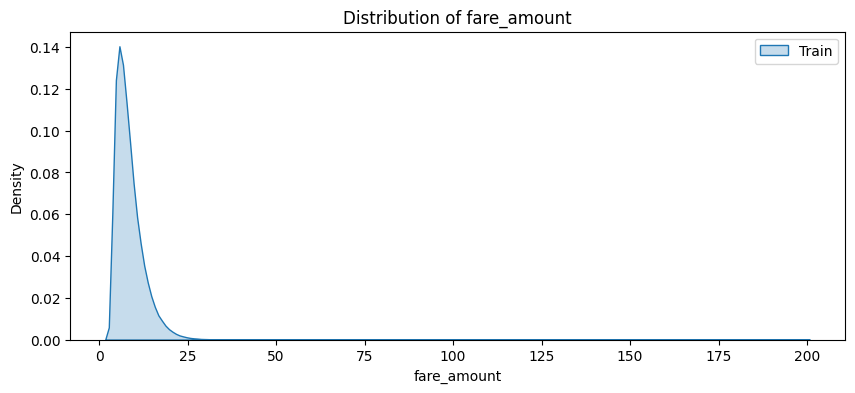

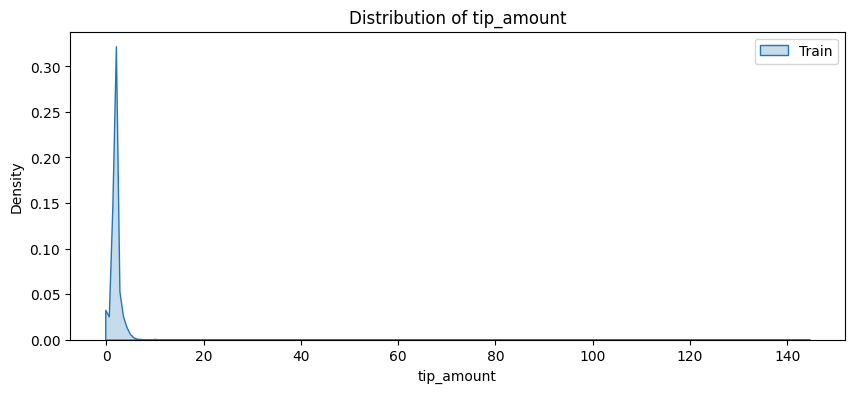

In [ ]:
for col in ['fare_amount', 'tip_amount']:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(train[col], label='Train', fill=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

From the graph, we observed a distribution mismatch in tip_amount between the train and validation sets, so we will apply a log transformation to reduce skewness.

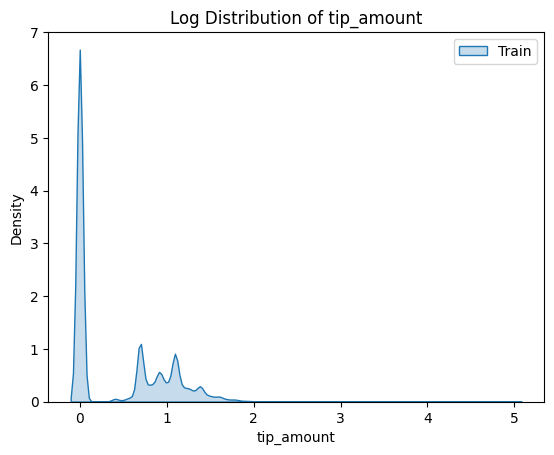

In [ ]:
sns.kdeplot(np.log1p(train['tip_amount']), label='Train', fill=True)
plt.title('Log Distribution of tip_amount')
plt.legend()
plt.show()

##### Dropping Irrelevant Variables

The `tip_paid` column is irrelevant for this task because it directly reflects whether a tip was given.
Since our goal is to predict the actual `tip_amount`, using `tip_paid` would introduce data leakage. Therefore, we will exclude it from our features.

In [ ]:
train = train.drop(columns='tip_paid')
test = test.drop(columns='tip_paid')

##### Handling Missing Values

Based on the previous EDA, missing values were found only in the `rate_code` column, with 103,795 missing entries, accounting for approximately 16.1% of the total 643,146 rows.

 Since the proportion is not too large and rate_code is a categorical feature, the missing values were imputed with a new category labeled 'Unknown'. (Combined with the handling outliers)

##### Distribution Categorical Variables

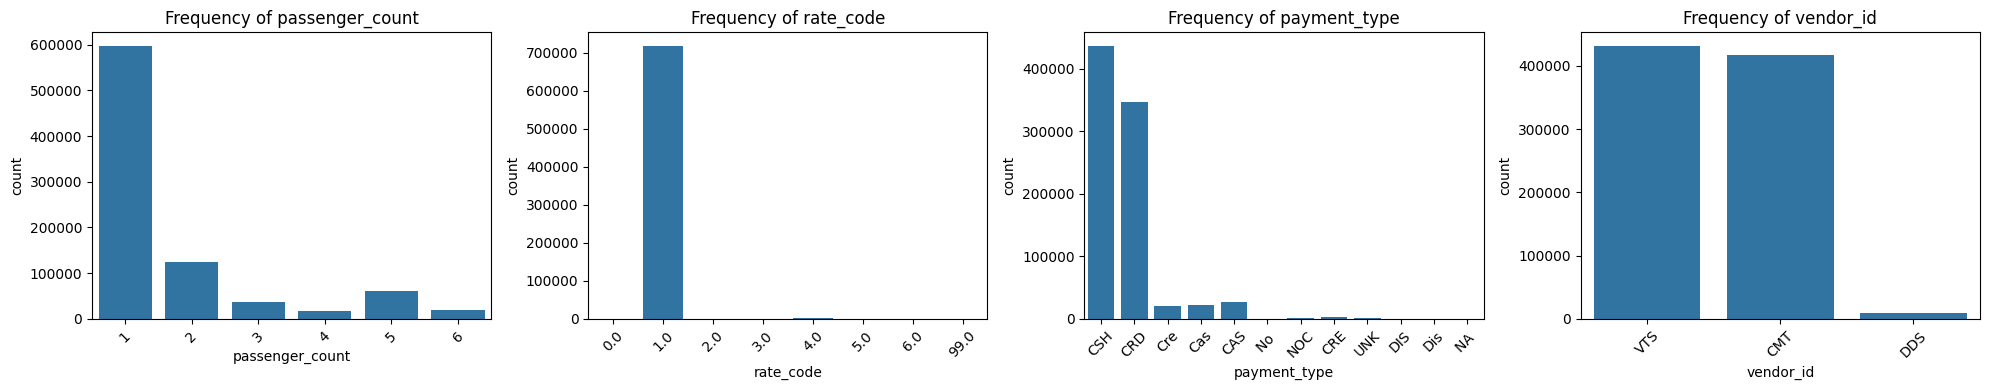

In [ ]:
categorical = ['passenger_count', 'rate_code', 'payment_type', 'vendor_id']

fig, axes = plt.subplots(1, len(categorical), figsize=(5 * len(categorical), 4))

for i, col in enumerate(categorical):
    sns.countplot(x=col, data=train, ax=axes[i])
    axes[i].set_title(f'Frequency of {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

From the previous analysis and the document i quoted in the [NYC Taxi](https://www.nyc.gov/assets/tlc/downloads/pdf/taxi_information.pdf) document, we identified `rate_code` > 6 is an outlier and handled it by reassigning it to the 'Unknown' category.

##### Handling Outliers

In [ ]:
for df in [train, test, test_data]:
    df['rate_code'] = df['rate_code'].astype(str)

valid = {'1.0', '2.0', '3.0', '4.0', '5.0', '6.0'}

for df in [train, test, test_data]:
    df['rate_code'] = df['rate_code'].where(df['rate_code'].isin(valid), 'Unknown')

In [ ]:
for df in [train, test, test_data]:
  df[
      (df['pickup_latitude'] < 40.5) | (df['pickup_latitude'] > 41.0) |
      (df['pickup_longitude'] < -74.3) | (df['pickup_longitude'] > -73.6) |
      (df['dropoff_latitude'] < 40.5) | (df['dropoff_latitude'] > 41.0) |
      (df['dropoff_longitude'] < -74.3) | (df['dropoff_longitude'] > -73.6)
  ]

##### Distribution Numerical Variables

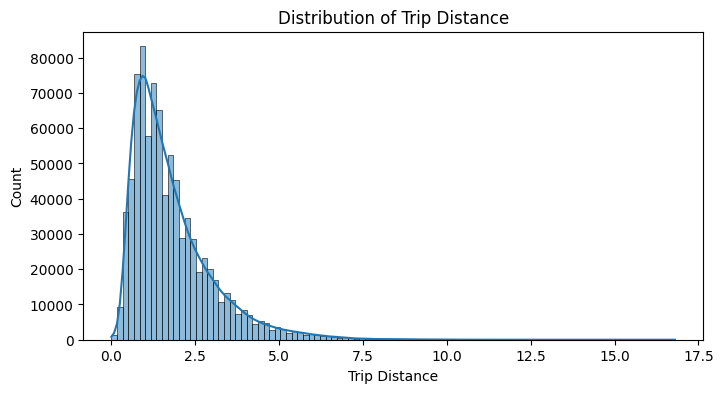

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(train['trip_distance'], bins=100, kde=True)
plt.title(f'Distribution of Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel("Count")
plt.show()

### Feature Engineering

Cash?

In [ ]:
for df in [train, test, test_data]:
    df['payment_type'] = df['payment_type'].str.upper()
    df['payment_type'] = df['payment_type'].replace({'CAS': 'CSH', 'CRE': 'CRD'})
    df['payment_type'] = df['payment_type'].where(df['payment_type'].isin(['CSH', 'CRD']), 'OTHER')

##### Time Zone Transformation

In [ ]:
for df in [train, test, test_data]:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True)
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], utc=True)
    df['pickup_datetime'] = df['pickup_datetime'].dt.tz_convert('US/Eastern') #Automatically detects EST or EDT
    df['dropoff_datetime'] = df['dropoff_datetime'].dt.tz_convert('US/Eastern') #Automatically detects EST or EDT

##### Distance & Duration of Trip

In [ ]:
for df in [train, test, test_data]:
    df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 3600.0

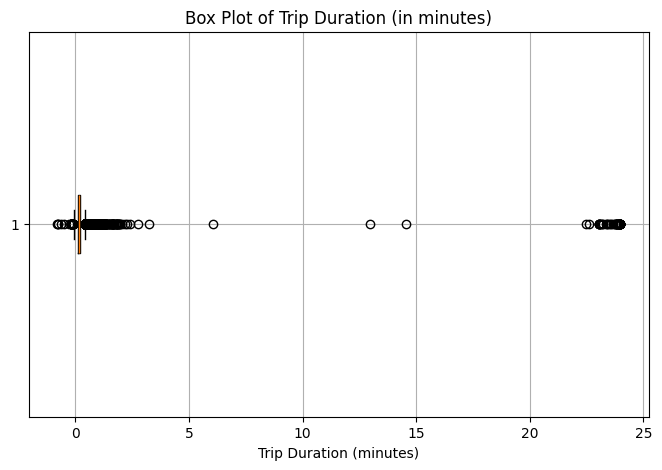

In [ ]:
plt.figure(figsize=(8, 5))
plt.boxplot(train['trip_duration'], vert=False, showfliers=True)
plt.title("Box Plot of Trip Duration (in minutes)")
plt.xlabel("Trip Duration (minutes)")
plt.grid(True)
plt.show()

##### Pickup Hour & Day of Week

In [ ]:
for df in [train, test, test_data]:
    df['pickup_rush_hour'] = df['pickup_datetime'].dt.hour.isin([7, 8, 16, 17, 18]).astype(int)
    df['pickup_weekend'] = df['pickup_datetime'].dt.dayofweek.isin([5, 6]).astype(int)

In [ ]:
for df in [train, test, test_data]:
    df['dropoff_rush_hour'] = df['dropoff_datetime'].dt.hour.isin([7, 8, 16, 17, 18]).astype(int)
    df['dropoff_weekend'] = df['dropoff_datetime'].dt.dayofweek.isin([5, 6]).astype(int)

##### Trip Speed & Remove Impossible Trips

In [ ]:
# Speed = distance (km) / time (hr)
for df in [train, test, test_data]:
    df['trip_distance_km'] = np.expm1(df['trip_distance'])
    df['speed'] = df['trip_distance_km'] / df['trip_duration']
    df.drop(df[(df['speed'] > 80) | (df['speed'] < 1)].index, inplace=True)
    df.drop(df[(df['speed'] <5) | (df['speed'] < 1)].index, inplace=True)

Impossible Trips

In [ ]:
for df in [train, test, test_data]:
    df.drop(df[(df['trip_duration'] <=0) & (df['trip_distance'] > 0)].index, inplace=True)
    df.drop(df[df['trip_duration'] > 24].index, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [ ]:
url = "https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson"
boroughs = gpd.read_file(url).to_crs(epsg=4326)
boroughs = boroughs.rename(columns={'BoroName': 'borough'})  # Adjust if needed

dropoff_gdf = gpd.GeoDataFrame(
    train,
    geometry=gpd.points_from_xy(train['dropoff_longitude'], train['dropoff_latitude']),
    crs='EPSG:4326'
)

dropoff_with_borough = gpd.sjoin(dropoff_gdf, boroughs[['borough', 'geometry']], how='left', predicate='within')
train['dropoff_borough'] = dropoff_with_borough['borough']

In [ ]:
borough_colors = {
    'Manhattan': 'red',
    'Brooklyn': 'blue',
    'Queens': 'green',
    'Bronx': 'orange',
    'JFK': 'black',
    'Other': 'purple',
    'Unknown': 'pink'
}

plt.figure(figsize=(5, 5))


for borough, color in borough_colors.items():
    subset = train[train['dropoff_borough'] == borough]
    plt.scatter(
        subset['dropoff_longitude'],
        subset['dropoff_latitude'],
        s=1,
        alpha=0.4,
        c=color,
        label=borough
    )

plt.title("Dropoff Locations by Borough")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(markerscale=10)
plt.grid(True)
plt.show()

KeyboardInterrupt: 

##### One Hot Encoding

###### Passenger Count

In [ ]:
categorical_cols = ['passenger_count', 'vendor_id','rate_code','payment_type']

train = pd.get_dummies(train, columns=categorical_cols, prefix=categorical_cols)
test = pd.get_dummies(test, columns=categorical_cols, prefix=categorical_cols)

##### Correlation Matrix

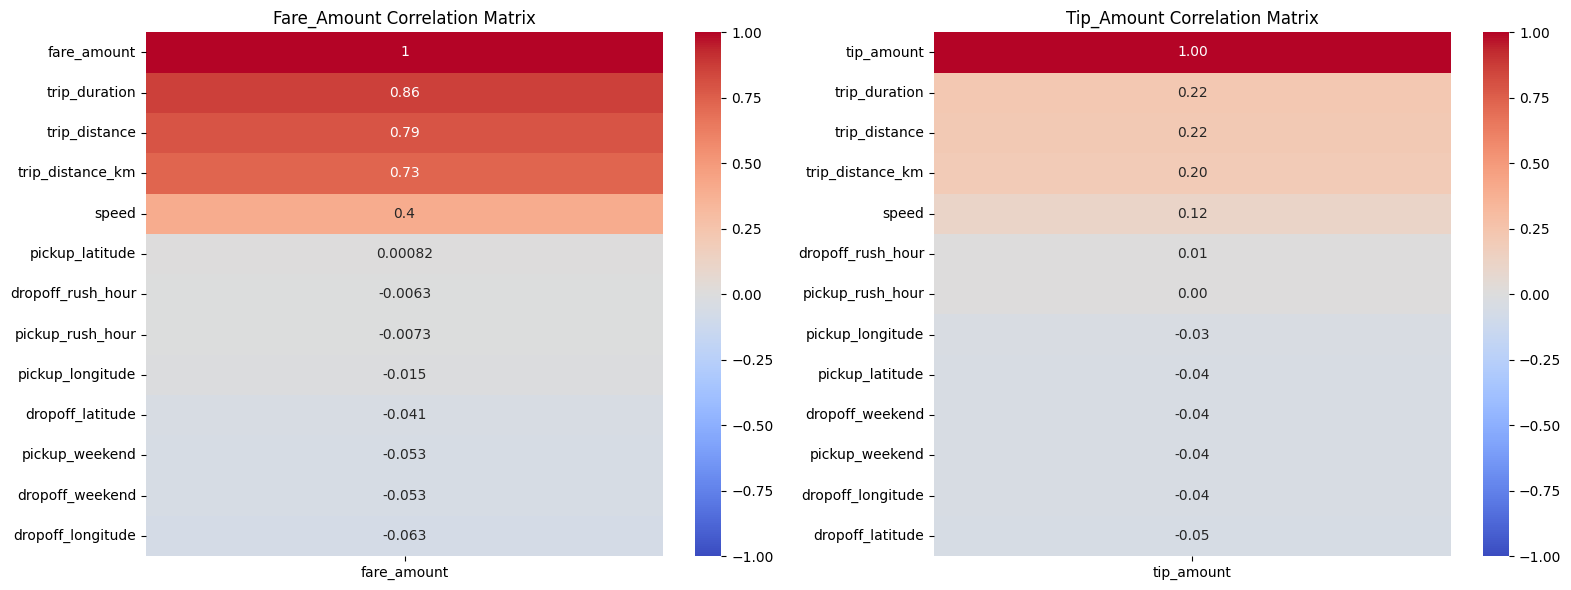

In [ ]:
numeric_cols = train.select_dtypes(include=['number'])

fare_corr_matrix = numeric_cols.drop(columns=['tip_amount']).corr()
tip_corr_matrix = numeric_cols.drop(columns=['fare_amount']).corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(fare_corr_matrix[['fare_amount']].sort_values(by='fare_amount', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Fare_Amount Correlation Matrix")
sns.heatmap(tip_corr_matrix[['tip_amount']].sort_values(by='tip_amount', ascending=False),
            annot=True, fmt=".2f", cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Tip_Amount Correlation Matrix")

plt.tight_layout()
plt.show()

### Models

In [ ]:
X_fare_train = train.drop(columns=['fare_amount', 'tip_amount','pickup_datetime', 'dropoff_datetime','trip_distance_km'])
y_fare_train = train['fare_amount']
X_tip_train = train.drop(columns=['fare_amount', 'tip_amount','pickup_datetime', 'dropoff_datetime','trip_distance_km'])
y_tip_train =  train['tip_amount']

X_test = test.drop(columns=['fare_amount', 'tip_amount','pickup_datetime', 'dropoff_datetime','trip_distance_km'])
y_fare_test = test['fare_amount']
y_tip_test = test['tip_amount']

# print(X_test.shape, y_fare_test.shape, y_tip_test.shape)

##### Random Forest

###### Fare Amount RMSE

In [41]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_dist,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=3,
    n_jobs=1,
    return_train_score=True
)

grid_search.fit(X_fare_train, y_fare_train)

best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
best_rmse = -grid_search.best_score_
print("Best RMSE (CV):", best_rmse)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END max_depth=5, n_estimators=50;, score=(train=-0.985, test=-1.057) total time= 1.4min
[CV 2/3] END max_depth=5, n_estimators=50;, score=(train=-1.024, test=-1.024) total time= 1.4min
[CV 3/3] END max_depth=5, n_estimators=50;, score=(train=-0.989, test=-1.141) total time= 1.4min
[CV 1/3] END max_depth=5, n_estimators=100;, score=(train=-0.982, test=-1.057) total time= 2.9min
[CV 2/3] END max_depth=5, n_estimators=100;, score=(train=-1.022, test=-1.020) total time= 2.9min
[CV 3/3] END max_depth=5, n_estimators=100;, score=(train=-0.987, test=-1.137) total time= 2.9min
[CV 1/3] END max_depth=5, n_estimators=200;, score=(train=-0.983, test=-1.059) total time= 5.8min
[CV 2/3] END max_depth=5, n_estimators=200;, score=(train=-1.022, test=-1.017) total time= 5.7min
[CV 3/3] END max_depth=5, n_estimators=200;, score=(train=-0.986, test=-1.137) total time= 5.7min
[CV 1/3] END max_depth=10, n_estimators=50;, score=(train=-0.

In [42]:
y_test_pred = best_rf.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_fare_test, y_test_pred))
print("RMSE:", rmse_test)

RMSE: 0.9217144102749875


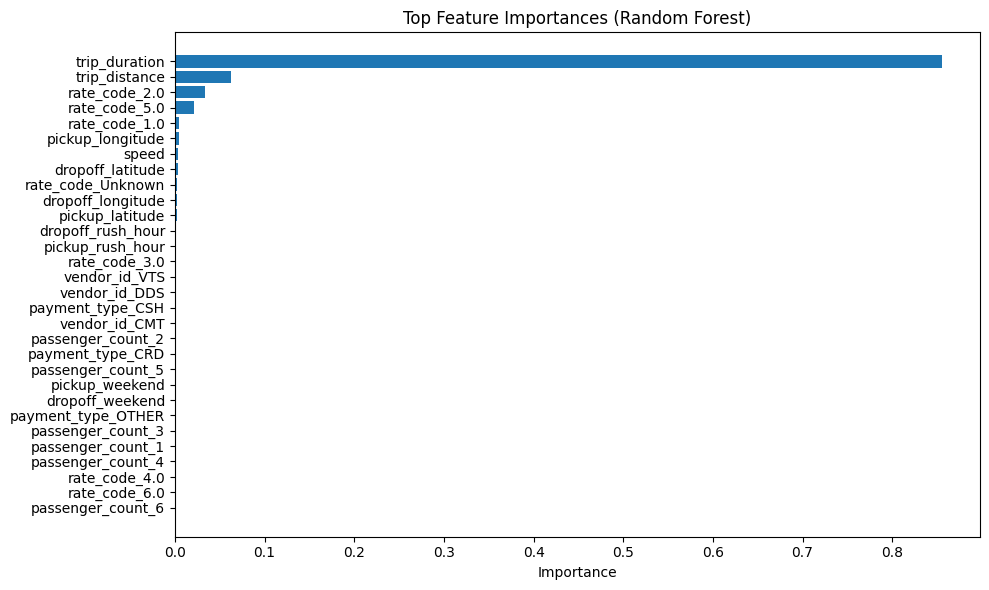

In [43]:
importances = best_rf.feature_importances_
feature_names = X_fare_train.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Importance')
plt.title('Top Feature Importances (Random Forest)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()

###### Tip Amount RMSE

In [ ]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=3,
    n_jobs=1,
    random_state=42
)

random_search.fit(X_tip_train, y_tip_train)

best_rf = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)
best_rmse = -random_search.best_score_
print("Best RMSE (CV):", best_rmse)

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .....max_depth=5, n_estimators=50;, score=-0.593 total time=   5.7s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


[CV 2/3] END .....max_depth=5, n_estimators=50;, score=-0.658 total time=   4.5s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


[CV 3/3] END .....max_depth=5, n_estimators=50;, score=-0.627 total time=   4.8s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


[CV 1/3] END ....max_depth=5, n_estimators=100;, score=-0.593 total time=   8.0s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


[CV 2/3] END ....max_depth=5, n_estimators=100;, score=-0.658 total time=   7.4s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


[CV 3/3] END ....max_depth=5, n_estimators=100;, score=-0.627 total time=   7.1s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


[CV 1/3] END ...max_depth=10, n_estimators=200;, score=-0.621 total time=  18.3s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


[CV 2/3] END ...max_depth=10, n_estimators=200;, score=-0.671 total time=  18.7s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


[CV 3/3] END ...max_depth=10, n_estimators=200;, score=-0.632 total time=  18.0s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


Best Parameters: {'n_estimators': 50, 'max_depth': 5}
Best RMSE (CV): 0.6261554104167909


In [ ]:
y_test_pred = best_rf.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_tip_test, y_test_pred))
print("RMSE:", rmse_test)

RMSE: 0.5066247745934079


In [ ]:
importances = best_rf.feature_importances_
feature_names = X_tip_train.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()

##### AdaBoostRegressor

Fare Amount RMSE

In [ ]:
base= DecisionTreeRegressor(random_state=42)
ada = AdaBoostRegressor(estimator=base, random_state=42)

param_dist = {
    'n_estimators': [50,100,150,200],
    'estimator__max_depth': [10,15]
}

random_search = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_dist,
    n_iter=5,
    verbose=3,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42
)

random_search.fit(X_fare_train, y_fare_train)

best_ada = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)
best_rmse = -random_search.best_score_
print("Best RMSE (CV):", best_rmse)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END estimator__max_depth=10, n_estimators=100;, score=-1.050 total time= 6.2min
[CV 2/3] END estimator__max_depth=10, n_estimators=100;, score=-0.928 total time= 6.5min
[CV 3/3] END estimator__max_depth=10, n_estimators=100;, score=-1.139 total time= 6.4min
[CV 1/3] END estimator__max_depth=15, n_estimators=100;, score=-0.972 total time=10.6min
[CV 2/3] END estimator__max_depth=15, n_estimators=100;, score=-0.767 total time=10.7min
[CV 3/3] END estimator__max_depth=15, n_estimators=100;, score=-1.154 total time=10.9min
[CV 1/3] END estimator__max_depth=10, n_estimators=50;, score=-0.978 total time= 3.6min
[CV 2/3] END estimator__max_depth=10, n_estimators=50;, score=-0.784 total time= 3.7min
[CV 3/3] END estimator__max_depth=10, n_estimators=50;, score=-1.021 total time= 3.7min
[CV 1/3] END estimator__max_depth=15, n_estimators=200;, score=-0.978 total time=20.1min
[CV 2/3] END estimator__max_depth=15, n_estimators=20

In [ ]:
y_test_pred = best_ada.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test_pred, y_fare_test))
print(f"Test RMSE: {rmse}")

Test RMSE: 1.0316392496960973


In [ ]:
base= DecisionTreeRegressor(random_state=42)
ada = AdaBoostRegressor(estimator=base, random_state=42)

param_dist = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.3, 1.0],
    'estimator__max_depth': [10, 15],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_dist,
    n_iter=16,
    verbose=3,
    return_train_score=True,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42
)

random_search.fit(X_tip_train, y_tip_train)

best_ada = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)
best_rmse = -random_search.best_score_
print("Best RMSE (CV):", best_rmse)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=10, learning_rate=0.3, n_estimators=100;, score=(train=-0.169, test=-0.353) total time= 8.7min
[CV 2/3] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=10, learning_rate=0.3, n_estimators=100;, score=(train=-0.171, test=-0.432) total time= 9.5min
[CV 3/3] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=10, learning_rate=0.3, n_estimators=100;, score=(train=-0.172, test=-0.397) total time= 9.3min
[CV 1/3] END estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=10, learning_rate=0.1, n_estimators=100;, score=(train=-0.208, test=-0.354) total time= 6.8min
[CV 2/3] END estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=10, learning_rate=0.1, n_estimators=100;, score=(train=-0.213, test=-

In [ ]:
y_test_pred = best_ada.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test_pred, y_tip_test))
print(f"Test RMSE: {rmse}")

Test RMSE: 0.5052265934598901


In [ ]:
importances = best_ada.feature_importances_
feature_names = X_fare_train.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Importance')
plt.title('Top Feature Importances Tip Amount (ADA Boost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
base= DecisionTreeRegressor(random_state=42)
ada = AdaBoostRegressor(estimator=base, random_state=42)

param_dist = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.3, 1.0],
    'estimator__max_depth': [10, 15],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_dist,
    n_iter=16,
    verbose=3,
    return_train_score=True,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42
)

random_search.fit(X_fare_train, y_fare_train)

best_ada = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)
best_rmse = -random_search.best_score_
print("Best RMSE (CV):", best_rmse)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=10, learning_rate=0.3, n_estimators=100;, score=(train=-0.362, test=-1.142) total time= 9.5min
[CV 2/3] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=10, learning_rate=0.3, n_estimators=100;, score=(train=-0.367, test=-0.831) total time= 9.5min
[CV 3/3] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=10, learning_rate=0.3, n_estimators=100;, score=(train=-0.363, test=-1.252) total time= 9.4min
[CV 1/3] END estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=10, learning_rate=0.1, n_estimators=100;, score=(train=-0.467, test=-0.984) total time= 7.1min
[CV 2/3] END estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=10, learning_rate=0.1, n_estimators=100;, score=(train=-0.468, test=-

In [ ]:
y_test_pred = best_ada.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test_pred, y_fare_test))
print(f"Test RMSE: {rmse}")

Test RMSE: 0.8961043597849581


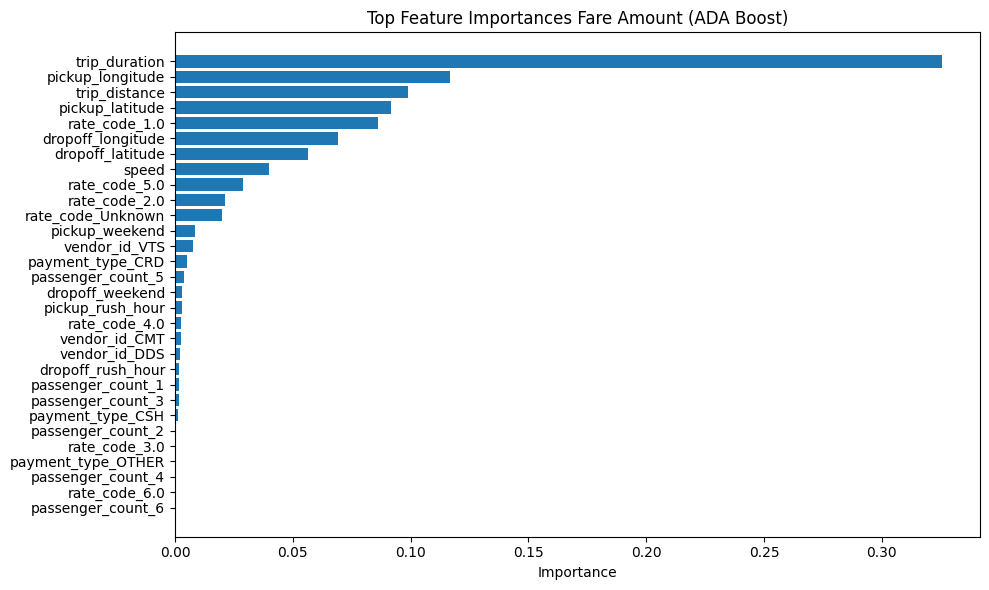

In [34]:
importances = best_ada.feature_importances_
feature_names = X_fare_train.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Importance')
plt.title('Top Feature Importances Fare Amount (ADA Boost)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()

##### Gradient Boosting Regressor

In [23]:
gbr = GradientBoostingRegressor(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0]
}
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=16,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=3,
    return_train_score=True,
)

random_search.fit(X_fare_train, y_fare_train)
best_gbr = random_search.best_estimator_

# Predict and evaluate
y_pred = best_gbr.predict(X_test)
rmse = mean_squared_error(y_fare_test, y_pred, squared=False)

print("Best Parameters:", random_search.best_params_)
print("Best CV RMSE:", -random_search.best_score_)
print("Test RMSE:", rmse)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.05, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8;, score=(train=-0.667, test=-0.933) total time= 6.6min
[CV 2/3] END learning_rate=0.05, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8;, score=(train=-0.674, test=-0.874) total time= 6.6min
[CV 3/3] END learning_rate=0.05, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8;, score=(train=-0.669, test=-1.024) total time= 6.6min
[CV 1/3] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=-0.866, test=-0.943) total time= 1.9min
[CV 2/3] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=-0.906, test=-0.845) total time= 1.9min
[CV 3/3] END learning_rate=0.05, max_depth=3, min_samples_leaf=1

TypeError: got an unexpected keyword argument 'squared'

In [26]:
y_pred = best_gbr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test_pred, y_fare_test))

print("Best Parameters:", random_search.best_params_)
print("Best CV RMSE:", -random_search.best_score_)
print("Test RMSE:", rmse)

Best Parameters: {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}
Best CV RMSE: 0.9201951073292505
Test RMSE: 0.8961043597849581


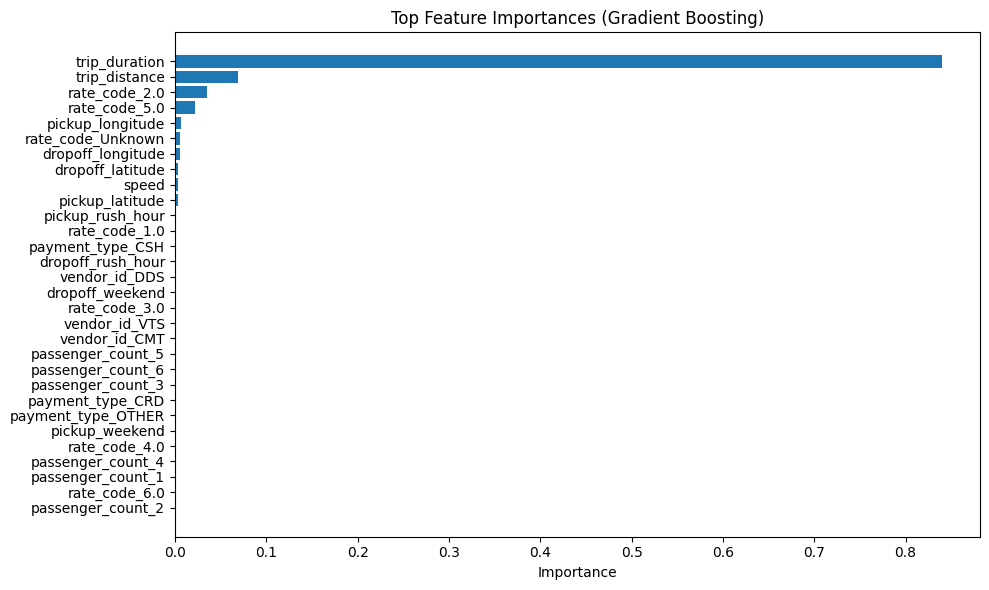

In [29]:
importances = best_gbr.feature_importances_
feature_names = X_fare_train.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Importance')
plt.title('Top Feature Importances (Gradient Boosting)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()

In [ ]:
gbr = GradientBoostingRegressor(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0]
}
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=16,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=3,
    return_train_score=True,
)

random_search.fit(X_tip_train, y_tip_train)
best_gbr = random_search.best_estimator_

# Predict and evaluate
y_pred = best_gbr.predict(X_test)
rmse = mean_squared_error(y_tip_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print("Best CV RMSE:", -random_search.best_score_)
print("Test RMSE:", rmse)

In [ ]:
y_pred = best_gbr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test_pred, y_tip_test))
print("Test RMSE:", rmse)

### Models (Subset Data)

### References

- Rate Code : https://www.nyc.gov/assets/tlc/downloads/pdf/taxi_information.pdf
- US Timezones : https://www.timeanddate.com/time/zones/est
- AdaBoostRegressor : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html